# 1. Entendimiento y preparacion de los datos
En primer lugar se va a realizar una perfilacion de los datos y un analisis de la calidad.

## 1.1. Exploracion y visualizacion

In [236]:
import sys
import pandas as pd
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

import numpy as np
np.random.seed(3301)

import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

import nltk

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 
from sklearn import tree
import sklearn as sklearn

In [162]:
db_location = './ODScat_345.xlsx'
df_ods=pd.read_excel(db_location)

In [163]:
df_ods.sample(10)

,Textos_espanol,sdg
3202,"Por lo tanto, necesitan desarrollar fuertes ví...",4
2667,"Prensa feminista, 2007), pág. 212. Comenzó a e...",5
1374,"El maestro de preescolar, el maestro de primer...",4
1106,Aquellos que hablan un idioma europeo tienen p...,4
4022,"Además, el plan no solo cubre al ejército cana...",5
1344,Esto significa asegurar que las escuelas cumpl...,4
2222,"En consecuencia, la inversión gubernamental en...",5
225,El estudio lleva a cabo un análisis comparativ...,3
773,Los conjuntos de datos incluidos en este estud...,3
1757,"También señaló que, si bien dichas evaluacione...",4


In [164]:
df_ods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


### 1.1.1. Tokenizacion
Aplicamos eliminacion de contracciones y tokenizacion del mensaje, es decir, transformamos el string en una lista de palabras separadas.

In [166]:
df_ods['Textos_espanol'] = df_ods['Textos_espanol'].apply(contractions.fix)
df_ods['words'] = df_ods['Textos_espanol'].apply(word_tokenize)
df_ods.head()

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [167]:
df_ods['words'].dropna()

0       [Por, ejemplo, ,, el, nÃºmero, de, consultas, ...
1       [En, 2007, ,, el, gobierno, central, financió,...
2       [Claramente, ,, hay, muchos, otros, factores, ...
3       [Por, ejemplo, ,, el, estado, australiano, de,...
4       [El, consumo, anual, de, alcohol, se, estima, ...
                              ...                        
4044    [Para, ello, ,, identificará, las, cuestiones,...
4045    [La, participación, de, las, mujeres, en, role...
4046    [Según, el, WEF, ,, según, las, tendencias, de...
4047    [Sirve, como, recurso, y, foro, para, las, age...
4048    [Las, áreas, útiles, para, un, mayor, estudio,...
Name: words, Length: 4049, dtype: object

In [168]:
df_ods['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4049 entries, 0 to 4048
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
4049 non-null   object
dtypes: object(1)
memory usage: 31.8+ KB


### 1.1.2. Preprocesamiento
Eliminamos los caracteres no-ASCII, removemos las puntuaciones, y transformamos todo a minuscula.

In [170]:
def remove_non_ascii(words):
    new_words=[]
    for word in words:
        if word is not None:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8','ignore')
            new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words=[]
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]','',word)
            if new_word !='':
                new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words=[]
    for word in words:
        if word is not None:
            new_word = word.lower()
            new_words.append(new_word)
    return new_words

def preprocessing(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = to_lowercase(words)
    return words

In [174]:
df_ods['words'] = df_ods['words'].apply(preprocessing)
df_ods.head()

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[por, ejemplo, el, naomero, de, consultas, ext..."
1,"En 2007, el gobierno central financió directam...",3,"[en, 2007, el, gobierno, central, financio, di..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, hay, muchos, otros, factores, en,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[por, ejemplo, el, estado, australiano, de, vi..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[el, consumo, anual, de, alcohol, se, estima, ..."


### 1.1.3. Normalizacion
Eliminamos prefijos y sufijos, y aplicamos lematizacion de verbos.\
Finalmente volvemos a transformar el mensaje a un string.

In [176]:
def stem_and_lemmatize(words):
    ls = LancasterStemmer()
    wnl = WordNetLemmatizer()
    
    new_words = []
    for word in words:
        if word is not None:
            new_word = ls.stem(word)
            new_word = wnl.lemmatize(new_word, pos="v")
            new_words.append(new_word)
    return new_words

df_ods['words'] = df_ods['words'].apply(stem_and_lemmatize)
df_ods.head()

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[por, ejemplo, el, naomero, de, consulta, exte..."
1,"En 2007, el gobierno central financió directam...",3,"[en, 2007, el, gobierno, cent, financio, direc..."
2,"Claramente, hay muchos otros factores en juego...",3,"[clara, hay, mucho, otro, fact, en, juego, en,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[por, ejemplo, el, estado, australiano, de, vi..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[el, consumo, an, de, alcohol, se, estim, en, ..."


In [177]:
df_ods['words'] = df_ods['words'].apply(lambda x: ' '.join(map(str, x)))
df_ods

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,por ejemplo el naomero de consulta externa de ...
1,"En 2007, el gobierno central financió directam...",3,en 2007 el gobierno cent financio directa solo...
2,"Claramente, hay muchos otros factores en juego...",3,clara hay mucho otro fact en juego en particul...
3,"Por ejemplo, el estado australiano de Victoria...",3,por ejemplo el estado australiano de victor cr...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,el consumo an de alcohol se estim en 157 litro...
...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,par ello identificar las cuest de genero mas d...
4045,La participación de las mujeres en roles de li...,5,la participac de las muj en rol de liderazgo d...
4046,"Según el WEF, según las tendencias de 2016, po...",5,segun el wef segun las tendencia de 2016 podr ...
4047,"Sirve como recurso y foro para las agencias, c...",5,sirv como recurso y foro par las agencia con e...


## 1.2 Calidad de los datos
### 1.2.1 Completitud.
Vemos que no existen filas con valores vacios. 

In [179]:
((df_ods.isnull().sum()/df_ods.shape[0])).sort_values(ascending=False)

Textos_espanol    0.0
sdg               0.0
words             0.0
dtype: float64

### 1.2.2. Duplicidad
Vemos que no existen filas duplicadas

In [181]:
print(df_ods.duplicated(keep=False).sum())

0


### 1.2.3. Consistencia y Validez
Solo contamos con dos columnas: el texto y la variable objetivo que debemos calcular, por lo que asumimos que las etiquetas estan bien puestas y por lo tanto son consistentes.

Todas las columnas son relevantes para el objetivo del negocio.

Podemos proseguir a la aplicacion de los modelos.

# 2. Modelado y evaluacion. Aplicacion de algoritmos
En primer lugar vamos a separar los datos, siendo Y la variable objetivo con los valores del ODS, y X la variable independiente con los textos correspondientes. 

Tambien vamos a separar el conjunto de los datos en el conjunto de entrenamiento y el conjunto de testeo.

## 2.1 Arbol de decision

### 2.1.1 Primer modelamiento. 
Se realizo un primer modelo de arbol de decision utilizando como parametros:
* Criterio de gini
* Profundidad maxima de 4
* Todas las palabras del dataframe
  
El objetivo es correr este primer modelo y posteriormente compararlo con otras instancias del modelo que tengan parametros diferentes, para asi encontrar los parametros optimos.

In [188]:
X = df_ods['words']
X = X.astype(str)
Y = df_ods['sdg']
Y = Y.astype(int)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X)
X = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [197]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)
arbol

DecisionTreeClassifier(max_depth=4, random_state=0)

In [199]:
arbol = arbol.fit(X_train, Y_train)
arbol

DecisionTreeClassifier(max_depth=4, random_state=0)

In [201]:
Y_pred = arbol.predict(X_test)

              precision    recall  f1-score   support

           3       0.96      0.66      0.78       269
           4       0.72      0.95      0.82       266
           5       0.92      0.92      0.92       275

    accuracy                           0.84       810
   macro avg       0.87      0.84      0.84       810
weighted avg       0.87      0.84      0.84       810



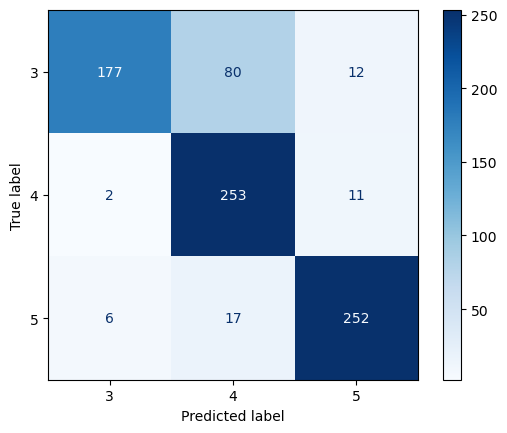

In [202]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, Y_pred))

### 2.1.2 Interpretacion del modelo y ejecucion nueva tomando en cuenta las palabras significativas y los parametros optimos.
Podemos determinar cuáles raizes de palabras son las más importantes a partir del modelo generado. Como podemos observar, realmente solo unas cuantas palabras son importantes de entre las diez miles que se le pasaron al modelo. De este modo pudimos identificar facilmente cuales palabras realmente son significativas para el modelo. En este caso se pudieron identificar las siguientes, en orden de importancia:

In [206]:
importancia= arbol.feature_importances_
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo.head(20)

,Atributo,Importancia
0,muj,0.521239
1,salud,0.229437
2,genero,0.102491
3,pacy,0.083533
4,enfermedad,0.019504
5,mortalidad,0.009408
6,sex,0.007609
7,embarazada,0.006487
8,educac,0.005558
9,estudy,0.005299


A continuacion vamos a determinar cuales son los mejores parametros de entrada para nuestro arbol de decision. Vamos a identificar el valor de estos parametros usando el metodo del conjunto de validacion. 
* Como se puede observar, el valor optimo de profundidad maxima del arbol es de 25.
* El valor optimo de criterion es utilizando el coeificiente de gini.

In [209]:
X_trainval, X_val, Y_trainval, Y_val = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 0)

In [211]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 2, random_state=0)
arbol = arbol.fit(X_trainval,Y_trainval)
y_pred_train = arbol.predict(X_trainval)
y_pred_val = arbol.predict(X_val)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_trainval, y_pred_train))
print('Exactitud sobre validación: %.2f' % accuracy_score(Y_val, y_pred_val))

Exactitud sobre entrenamiento: 0.79
Exactitud sobre validación: 0.80


In [213]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 8, random_state=0)
arbol = arbol.fit(X_trainval,Y_trainval)
y_pred_train = arbol.predict(X_trainval)
y_pred_val = arbol.predict(X_val)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_trainval, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_val, y_pred_val))

Exactitud sobre entrenamiento: 0.93
Exactitud sobre test: 0.91


In [215]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 10, random_state=0)
arbol = arbol.fit(X_trainval,Y_trainval)
y_pred_train = arbol.predict(X_trainval)
y_pred_val = arbol.predict(X_val)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_trainval, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_val, y_pred_val))

Exactitud sobre entrenamiento: 0.95
Exactitud sobre test: 0.92


In [217]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 20, random_state=0)
arbol = arbol.fit(X_trainval,Y_trainval)
y_pred_train = arbol.predict(X_trainval)
y_pred_val = arbol.predict(X_val)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_trainval, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_val, y_pred_val))

Exactitud sobre entrenamiento: 0.99
Exactitud sobre test: 0.93


In [219]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 25, random_state=0)
arbol = arbol.fit(X_trainval,Y_trainval)
y_pred_train = arbol.predict(X_trainval)
y_pred_val = arbol.predict(X_val)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_trainval, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_val, y_pred_val))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.93


### 2.1.3. Modelo de arbol de decision nuevo:
El nuevo arbol de decision fue modelado teniendo en cuenta:
* Criterio de coeficiente de gini.
* Palabras (columnas) significativas segun su importancia en la decision.
* Profundidad maxima del arbol de 25.

              precision    recall  f1-score   support

           3       0.98      0.78      0.87       269
           4       0.81      0.97      0.88       266
           5       0.94      0.94      0.94       275

    accuracy                           0.90       810
   macro avg       0.91      0.89      0.89       810
weighted avg       0.91      0.90      0.89       810



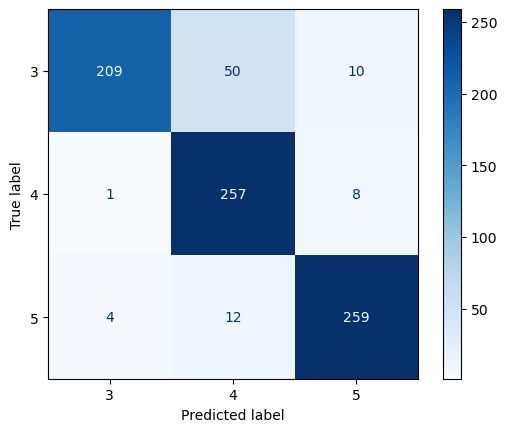

In [222]:
X = X[['muj','salud','genero','pacy','enfermedad','mortalidad','sex','embarazada','educac','estudy','ent','anticonceptivo','vih','ag']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

arbol = DecisionTreeClassifier(criterion='gini', max_depth=25, random_state=0)
arbol = arbol.fit(X_train, Y_train)
Y_pred = arbol.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, Y_pred))

## 2.2 K-Nearest Neighbors

### 2.2.1 Primer modelamiento

In [226]:
X = df_ods['words']
X = X.astype(str)
Y = df_ods['sdg']
Y = Y.astype(int)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X)
X = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [228]:
knn = KNeighborsClassifier(n_neighbors=3)
knn

KNeighborsClassifier(n_neighbors=3)

In [230]:
knn = knn.fit(X_train, Y_train)
knn

KNeighborsClassifier(n_neighbors=3)

              precision    recall  f1-score   support

           3       0.82      0.60      0.69       269
           4       0.65      0.94      0.77       266
           5       0.87      0.72      0.79       275

    accuracy                           0.75       810
   macro avg       0.78      0.75      0.75       810
weighted avg       0.78      0.75      0.75       810



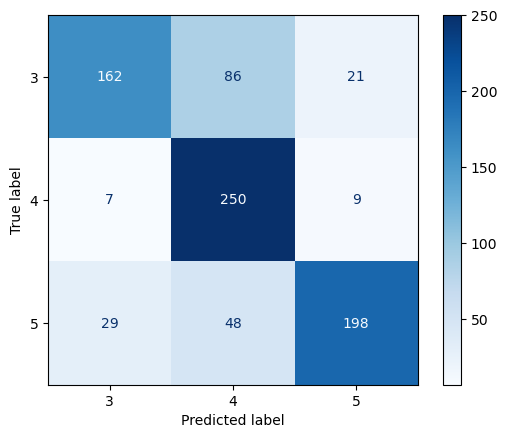

In [1944]:
Y_pred = knn.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, Y_pred))

### 2.2.2 Interpretacion del modelo y ejecucion nueva tomando en cuenta las palabras significativas y los parametros optimos.

Debido a que para el KNN classifier no es posible determinar con facilidad cuales atributos son los mas importantes para el proceso de seleccion, vamos a utilizar los resultados del modelo del arbol. Estas seran nuestras nuevas variables independientes optimas.

A continuacion vamos a determinar los hiperparametros para el modelo de KNN.

In [1949]:
X = df_ods['words']
X = X.astype(str)
Y = df_ods['sdg']
Y = Y.astype(int)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X)
X = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
X = X[['muj','salud','genero','pacy','enfermedad','mortalidad','sex','embarazada','educac','estudy','ent','anticonceptivo','vih','ag']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [1951]:
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,10))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_odd_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
mejor_modelo_knn.fit(X_train, Y_train)

#Print The value of best Hyperparameters
print('Best p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])

Best p: 1
Best n_neighbors: 9


### 2.2.3. Modelo de KNN nuevo:
Se realizo una ejecucion del KNN final con los parametros optimos calculados en la etapa anterior.

In [1954]:
# Mejor modelo
neigh_final = mejor_modelo_knn.best_estimator_
neigh_final

KNeighborsClassifier(n_neighbors=9, p=1)

In [1956]:
# Probemos ahora este modelo sobre test.
y_pred_train = neigh_final.predict(X_train)
y_pred_test = neigh_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.89
Exactitud sobre test: 0.89


              precision    recall  f1-score   support

           3       0.98      0.76      0.86       269
           4       0.79      0.97      0.87       266
           5       0.93      0.94      0.93       275

    accuracy                           0.89       810
   macro avg       0.90      0.89      0.89       810
weighted avg       0.90      0.89      0.89       810



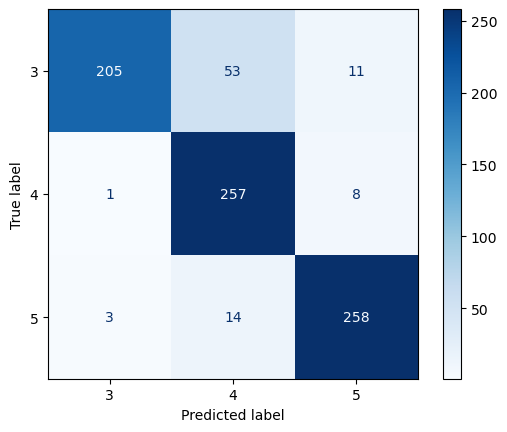

In [1958]:
cm = confusion_matrix(Y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh_final.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, y_pred_test))

## 2.3 AdaBoostClassifier

### 2.3.1 Primer modelamiento
En este caso, utilizamos todas las variables del dataframe, no solamente las mas significativas. Y obtuvimos un resultado superior al de todos los demas algoritmos. Los parametros del modelo fueron los siguientes:
* n_estimators = 100
* algorithm = "SAMME"

In [250]:
X = df_ods['words']
X = X.astype(str)
Y = df_ods['sdg']
Y = Y.astype(int)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X)
X = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
#X = X[['muj','salud','genero','pacy','enfermedad','mortalidad','sex','embarazada','educac','estudy','ent','anticonceptivo','vih','ag']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [252]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)

In [254]:
clf.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)

In [1895]:
Y_predict = clf.predict(X_test)

              precision    recall  f1-score   support

           3       0.92      0.94      0.93       269
           4       0.95      0.94      0.94       266
           5       0.94      0.93      0.94       275

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



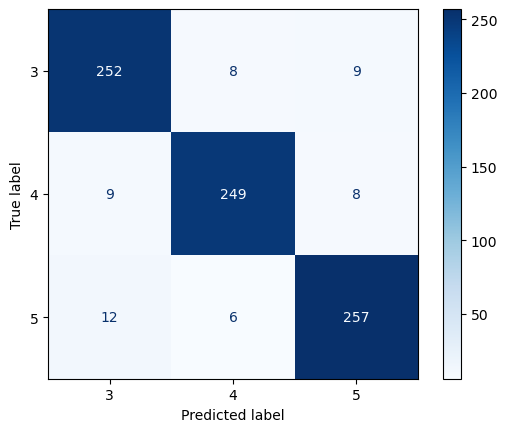

In [1896]:
cm = confusion_matrix(Y_test, Y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, Y_predict))

### 2.3.2 Interpretacion del modelo y ejecucion nueva tomando en cuenta las palabras significativas y los parametros optimos.
Se realizaron varias instancias del modelo con parametros entre 1 y 200, y se comprobo que el valor mas acertado es el de 100.
Del mismo modo, se realizo una ejecucion con las columnas mas significativas otorgadas por el modelo de arbol de decision, sin embargo no se tuvo un mejor resultado.

In [270]:
X = df_ods['words']
X = X.astype(str)
Y = df_ods['sdg']
Y = Y.astype(int)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X)
X = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
X = X[['muj','salud','genero','pacy','enfermedad','mortalidad','sex','embarazada','educac','estudy','ent','anticonceptivo','vih','ag']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [272]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)

In [274]:
clf.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)

In [276]:
Y_predict = clf.predict(X_test)

              precision    recall  f1-score   support

           3       0.88      0.83      0.85       269
           4       0.84      0.90      0.87       266
           5       0.94      0.93      0.94       275

    accuracy                           0.89       810
   macro avg       0.89      0.89      0.89       810
weighted avg       0.89      0.89      0.89       810



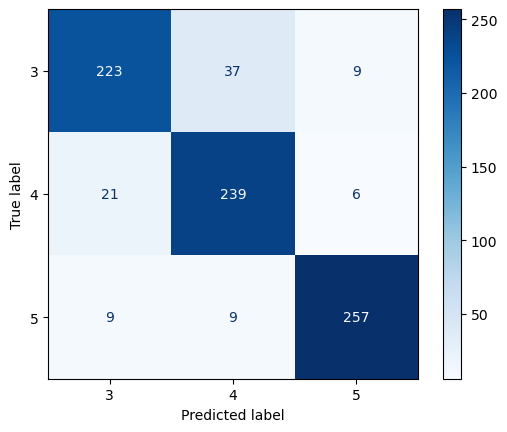

In [278]:
cm = confusion_matrix(Y_test, Y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

print(classification_report(Y_test, Y_predict))

### 2.3.3. Modelo de arbol de decision nuevo:
Debido a las pruebas realizadas, se escogio el modelo de AdaBoostClassifier con los parametros iniciales.


# 3. Algoritmo final seleccionado
Debido a los resultados obtenidos en la ejecucion de los 3 algoritmos: **Arbol de decision**, **K-Nearest Neighbors** y **Ada Boost Classifier**, asi como teniendo en cuenta las diferentes instancias ejecutadas con diferentes parametros, finalmente se selecciono el modelo de AdaBoostClassifier con los siguientes parametros de entrada:
* n_estimators = 100
* algorithm = "SAMME"
* datos de entrada: todas las columnas del dataframe, es decir, todas las palabras


En la Wiki del proyecto se encuentra un analisis a mayor profundidad acerca de la seleccion del modelo y las implicaciones que los resultados obtenidos tienen para el negocio.

# 4. Clasificacion de los datos de validacion utilizando el modelo escogido

In [283]:
db_location = './TestODScat_345.xlsx'
df_ods_test=pd.read_excel(db_location)


df_ods_test['Textos_espanol'] = df_ods_test['Textos_espanol'].apply(contractions.fix)
df_ods_test['words'] = df_ods_test['Textos_espanol'].apply(word_tokenize)
df_ods_test['words'].dropna()

df_ods_test['words'] = df_ods_test['words'].apply(preprocessing)


df_ods_test['words'] = df_ods_test['words'].apply(stem_and_lemmatize)
df_ods_test['words'] = df_ods_test['words'].apply(lambda x: ' '.join(map(str, x)))

print(((df_ods_test.isnull().sum()/df_ods_test.shape[0])).sort_values(ascending=False))
print(df_ods_test.duplicated(keep=False).sum())

X_test = df_ods_test['words']
X_test = X_test.astype(str)

vectorizer = CountVectorizer(binary=True)
X_vectorized = vectorizer.fit_transform(X_test)
X_test = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

sdg               1.0
Textos_espanol    0.0
words             0.0
dtype: float64
0


In [285]:
X_test = X_test[['muj','salud','genero','pacy','enfermedad','mortalidad','sex','embarazada','educac','estudy','ent','anticonceptivo','vih','ag']]


In [287]:
Y_predict = clf.predict(X_test)

In [291]:
df_ods_test['sdg'] = Y_predict

# Write the updated DataFrame to a new Excel file
output_file_path = './TestODScat_345.xlsx'
df_ods_test.to_excel(output_file_path, index=False)